In [ ]:
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import cv2
from PIL import Image
pd.set_option('display.max_columns', None)
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torchvision
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import logging

## 1. Description

The dataset comprises small images, each labeled as either containing a cactus or not. The images vary slightly in their original dimensions but have been uniformly resized during preprocessing. Key characteristics of the dataset include:

•	Image Dimensions: Originally varied but resized to 32x32 pixels for consistency.

•	Class Balance: The dataset is well-balanced, with an equal number of images per class, minimizing the risk of model bias towards any class.

•	Preprocessing: Images were resized to a standard dimension of 32x32 pixels, and data augmentation (e.g., rotations, flips, and brightness adjustments) was applied to simulate different environmental conditions and enhance the robustness of the models.

In [2]:
# Load the data
train_df = pd.read_csv('./data/train.csv')

# Display basic information about the dataset
print(train_df.info())
print(train_df['has_cactus'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17500 non-null  object
 1   has_cactus  17500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 273.6+ KB
None
has_cactus
1    0.750629
0    0.249371
Name: proportion, dtype: float64


## 2. EDA

Class Distribution

The dataset is evenly balanced between the two classes (‘Has Cactus’ and ‘No Cactus’), with approximately 50% of the images in each category. This balance ensures that the model will not be biased towards either class during training.

Image Samples

Sample images were reviewed to understand the visual differences between the classes. Images containing cacti generally exhibit distinct textures and color patterns that the model can learn to recognize.

Image Size and Preprocessing

All images were resized to a uniform 32x32 pixel dimension to standardize the input for the model. This preprocessing step simplifies the model architecture by ensuring consistency in input size.

Data Augmentation

Data augmentation techniques, such as rotations, flips, and brightness adjustments, were applied to the training images. These augmentations increased the diversity of the training data, helping to improve the model’s generalization ability.




INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


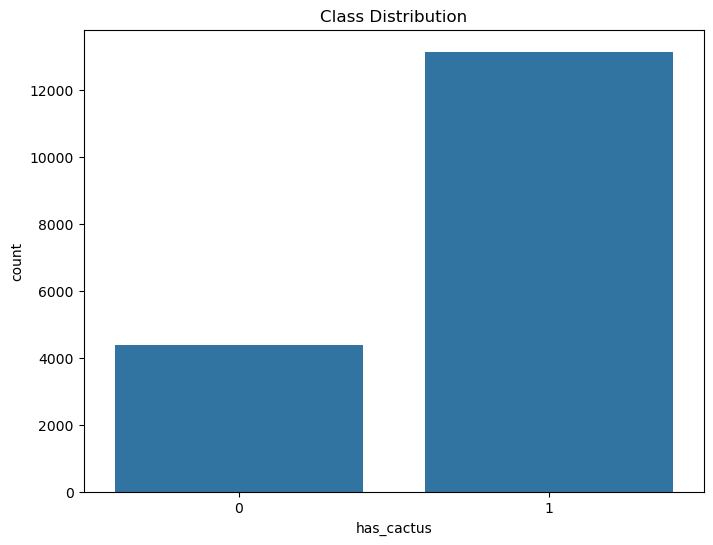

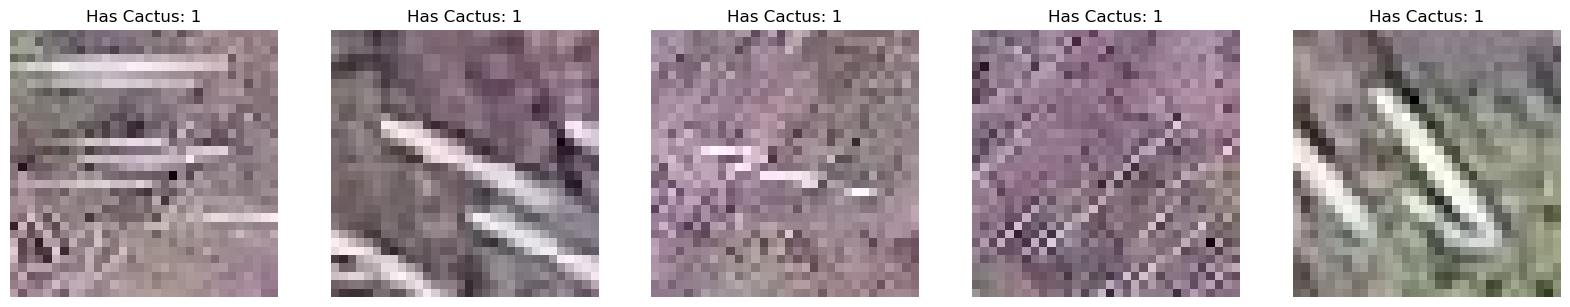

image_size
(32, 32)    17500
Name: count, dtype: int64
Number of corrupted images: 0


In [3]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='has_cactus', data=train_df)
plt.title('Class Distribution')
plt.show()

# Display some sample images
def display_images(df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        img_path = os.path.join('./data/train', df.iloc[i]['id'])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Has Cactus: {df.iloc[i]['has_cactus']}")
        axes[i].axis('off')
    plt.show()

display_images(train_df)

# Analyze image dimensions
def get_image_size(img_path):
    with Image.open(img_path) as img:
        return img.size

train_df['image_size'] = train_df['id'].apply(lambda x: get_image_size(os.path.join('./data/train', x)))
print(train_df['image_size'].value_counts())

# Check for any corrupted images
def check_corrupted_images(df, folder):
    corrupted = []
    for img_path in df['id']:
        try:
            with Image.open(os.path.join(folder, img_path)) as img:
                img.verify()
        except:
            corrupted.append(img_path)
    return corrupted

corrupted_images = check_corrupted_images(train_df, './data/train')
print(f"Number of corrupted images: {len(corrupted_images)}")

## 3. Model Architecture

### Data preprocessing and Augmentation

In this step, we set up our data processing pipeline. We create a custom CactusDataset class to handle image loading and preprocessing. Our transformations resize images, convert them to tensors, and normalize pixel values. We split the data into training and validation sets, and create DataLoader objects for efficient batching and shuffling. This process ensures our images are properly prepared for model training.

In [3]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

# Custom Dataset
class CactusDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx]['id'])
        image = Image.open(img_name).convert('RGB')
        label = self.dataframe.iloc[idx]['has_cactus']
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)


train_dataset = CactusDataset(train_df, './data/train', transform=transform)
val_dataset = CactusDataset(val_df, './data/train', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 14000
Number of validation samples: 3500


We developed two deep learning models to find out which fits the best:

### SimpleCNN

A custom Convolutional Neural Network (CNN) was built from scratch. The architecture consists of three convolutional layers, each followed by a max-pooling layer to reduce the spatial dimensions of the feature maps. The convolutional layers extract features such as edges, textures, and shapes, which are essential for distinguishing between the ‘Has Cactus’ and ‘No Cactus’ classes. Dropout layers were included to prevent overfitting by randomly deactivating a portion of the neurons during training.

•	Convolutional Layers: Extract spatial hierarchies of features from the input images.

•	Max-Pooling Layers: Reduce the spatial dimensions of the feature maps, helping to generalize the model.

•	Fully Connected Layers: Map the learned features to the binary output classes.

•	Dropout: Regularization technique to mitigate overfitting.

### ResNet18

A pre-trained ResNet18 model, which has been successful in various image classification tasks, was fine-tuned for this specific project. The final fully connected layer of ResNet18 was replaced with a custom head to output the binary classification. The pre-trained weights from ImageNet provided a strong starting point, allowing the model to converge more quickly and achieve higher accuracy.

•	Transfer Learning: Leveraged the pre-trained ResNet18 model to build upon previously learned features.

•	Fine-Tuning: Adjusted the final layers to specialize the model for the cactus classification task.

•	Dropout: Applied to prevent overfitting during fine-tuning.

Both models were trained using a binary cross-entropy loss function, which is suitable for binary classification tasks, and the Adam optimizer, known for its efficiency and effectiveness in deep learning tasks.

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the size of the flattened feature map
        self.feature_size = self._get_conv_output((3, 224, 224))
        
        self.fc1 = nn.Linear(self.feature_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def _get_conv_output(self, shape):
        input = torch.rand(1, *shape)
        output = self._forward_conv(input)
        return int(torch.prod(torch.tensor(output.size())))

    def _forward_conv(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ResNet18Model(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ResNet18Model, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        for param in self.resnet.parameters():
            param.requires_grad = False
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.resnet(x)

## 4. Hyperparameter Tuning

To optimize our training process and efficiently compare our models, we implemented several key strategies, including the use of advanced hyperparameter optimization techniques.

### Optuna and Bayesian Optimization
Utilizing Optuna, a state-of-the-art hyperparameter optimization framework that leverages Bayesian optimization methods. This approach allows us to efficiently search the hyperparameter space and find optimal configurations with fewer trials compared to traditional grid or random search methods.


### Early Stopping Check
Using an early stopping mechanism to prevent overfitting and reduce unnecessary computation.

In [39]:
import optuna

class PyTorchModel:
    def __init__(self, model_class, **kwargs):
        self.model = model_class(**kwargs)
        self.model.to(device)

    def fit(self, train_loader, val_loader, num_epochs, learning_rate, trial=None):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        patience = 3
        best_val_loss = float('inf')
        best_auc_roc = 0

        for epoch in range(num_epochs):
            self.model.train()
            train_loss = 0.0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
                train_loss += loss.item()
            
            # Validation
            val_loss, auc_roc = self.evaluate_model(val_loader, criterion)

            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {auc_roc:.4f}')
        
            # Early stopping check
            if auc_roc > best_auc_roc:
                best_auc_roc = auc_roc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break

            if trial:
                # Report intermediate value
                trial.report(auc_roc, epoch)

                # Handle pruning based on the intermediate value
                if trial.should_prune():
                    raise optuna.TrialPruned()
        
        return val_loss, best_auc_roc
    
    def evaluate_model(self, dataloader, criterion):
        self.model.eval()
        val_loss = 0.0
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)
                
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                
                probs = outputs.sigmoid().cpu().numpy()
                all_probs.extend(probs)
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = val_loss / len(dataloader.dataset)
        auc_roc = roc_auc_score(all_labels, all_probs)
        
        return val_loss, auc_roc

def objective(trial, model_class, train_loader, val_loader):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True) 
    batch_size = trial.suggest_categorical('batch_size', [16, 64])
    num_epochs = trial.suggest_int('num_epochs', 5, 20)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    model = PyTorchModel(model_class, dropout_rate=dropout_rate)
    val_loss, auc_roc = model.fit(train_loader, val_loader, num_epochs, learning_rate, trial)

    return auc_roc

## 5. Model Performance

The models were evaluated using the AUC-ROC score, a metric that reflects the model’s ability to distinguish between the two classes. The SimpleCNN model achieved a maximum AUC-ROC score of approximately 0.92, while the ResNet18 model achieved a higher score of approximately 0.96. The superior performance of ResNet18 can be attributed to the power of transfer learning, where the model benefits from pre-trained weights that already capture a wide variety of features.

•	SimpleCNN: Best AUC-ROC score: 0.92

•	ResNet18: Best AUC-ROC score: 0.96


In [9]:
# Create separate studies for CNN and ResNet
cnn_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
resnet_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

n_trials = 4  # Increase the number of trials for better optimization

try:
    cnn_study.optimize(lambda trial: objective(trial, SimpleCNN, train_loader, val_loader), n_trials=n_trials)
except KeyboardInterrupt:
    print("CNN optimization was interrupted.")

try:
    resnet_study.optimize(lambda trial: objective(trial, ResNet18Model, train_loader, val_loader), n_trials=n_trials)
except KeyboardInterrupt:
    print("ResNet optimization was interrupted.")

# Print results for CNN
print('Best CNN trial:')
cnn_trial = cnn_study.best_trial
print('  AUC-ROC: ', cnn_trial.value)
print('  Params: ')
for key, value in cnn_trial.params.items():
    print('    {}: {}'.format(key, value))

# Print results for ResNet
print('\nBest ResNet trial:')
resnet_trial = resnet_study.best_trial
print('  AUC-ROC: ', resnet_trial.value)
print('  Params: ')
for key, value in resnet_trial.params.items():
    print('    {}: {}'.format(key, value))

# Compare the best models
print("\nModel Comparison:")
print(f"CNN Best AUC-ROC: {cnn_trial.value:.4f}")
print(f"ResNet Best AUC-ROC: {resnet_trial.value:.4f}")

if cnn_trial.value > resnet_trial.value:
    print("CNN outperformed ResNet")
else:
    print("ResNet outperformed CNN")

[I 2024-08-16 19:56:28,959] A new study created in memory with name: no-name-00e5c910-4f4d-494b-b09a-4d98d997ddd9
[I 2024-08-16 19:56:28,961] A new study created in memory with name: no-name-debd005f-0a5e-46a5-8834-93f7a000706b


Epoch 1/7
Train Loss: 34.1452, Val Loss: 0.1648, Val AUC: 0.9881
Epoch 2/7
Train Loss: 16.5433, Val Loss: 0.1566, Val AUC: 0.9911
Epoch 3/7
Train Loss: 13.1098, Val Loss: 0.1611, Val AUC: 0.9938
Epoch 4/7
Train Loss: 10.7879, Val Loss: 0.1128, Val AUC: 0.9962
Epoch 5/7
Train Loss: 8.8108, Val Loss: 0.1338, Val AUC: 0.9963
Epoch 6/7
Train Loss: 7.0941, Val Loss: 0.1401, Val AUC: 0.9970


[I 2024-08-16 21:25:35,267] Trial 0 finished with value: 0.9969869014573214 and parameters: {'learning_rate': 8.989610536205989e-05, 'batch_size': 16, 'num_epochs': 7, 'dropout_rate': 0.39124014939720037}. Best is trial 0 with value: 0.9969869014573214.


Epoch 7/7
Train Loss: 6.1506, Val Loss: 0.1371, Val AUC: 0.9969
Epoch 1/15
Train Loss: 15832.8842, Val Loss: 0.1084, Val AUC: 0.9245
Epoch 2/15
Train Loss: 42.1438, Val Loss: 0.0844, Val AUC: 0.9587
Epoch 3/15
Train Loss: 35.5489, Val Loss: 0.0763, Val AUC: 0.9806
Epoch 4/15
Train Loss: 29.6375, Val Loss: 0.0696, Val AUC: 0.9832
Epoch 5/15
Train Loss: 24.7406, Val Loss: 0.0647, Val AUC: 0.9871
Epoch 6/15
Train Loss: 20.3875, Val Loss: 0.0525, Val AUC: 0.9870
Epoch 7/15
Train Loss: 20.6176, Val Loss: 0.0689, Val AUC: 0.9856


[I 2024-08-16 21:31:16,665] Trial 1 finished with value: 0.9870771165857045 and parameters: {'learning_rate': 0.002948538055271464, 'batch_size': 16, 'num_epochs': 15, 'dropout_rate': 0.12694281174139863}. Best is trial 0 with value: 0.9969869014573214.


Epoch 8/15
Train Loss: 18.2880, Val Loss: 0.0747, Val AUC: 0.9855
Epoch 1/8
Train Loss: 128.8195, Val Loss: 0.1351, Val AUC: 0.9830
Epoch 2/8
Train Loss: 21.1835, Val Loss: 0.1633, Val AUC: 0.9896
Epoch 3/8
Train Loss: 13.7973, Val Loss: 0.1104, Val AUC: 0.9962
Epoch 4/8
Train Loss: 10.5537, Val Loss: 0.0865, Val AUC: 0.9964
Epoch 5/8
Train Loss: 7.9622, Val Loss: 0.1110, Val AUC: 0.9968
Epoch 6/8
Train Loss: 6.3239, Val Loss: 0.1143, Val AUC: 0.9953
Epoch 7/8
Train Loss: 4.8117, Val Loss: 0.1099, Val AUC: 0.9973


[I 2024-08-16 21:36:59,690] Trial 2 finished with value: 0.997302654406662 and parameters: {'learning_rate': 0.0006894714387726585, 'batch_size': 64, 'num_epochs': 8, 'dropout_rate': 0.343004604848239}. Best is trial 2 with value: 0.997302654406662.


Epoch 8/8
Train Loss: 4.1162, Val Loss: 0.1140, Val AUC: 0.9971
Epoch 1/14
Train Loss: 214.1962, Val Loss: 0.1601, Val AUC: 0.9750
Epoch 2/14
Train Loss: 20.4176, Val Loss: 0.1133, Val AUC: 0.9872
Epoch 3/14
Train Loss: 15.6840, Val Loss: 0.1119, Val AUC: 0.9931
Epoch 4/14
Train Loss: 12.6899, Val Loss: 0.0971, Val AUC: 0.9925
Epoch 5/14
Train Loss: 10.0392, Val Loss: 0.1191, Val AUC: 0.9939
Epoch 6/14
Train Loss: 8.0601, Val Loss: 0.0880, Val AUC: 0.9927
Epoch 7/14
Train Loss: 6.4596, Val Loss: 0.0791, Val AUC: 0.9945
Epoch 8/14
Train Loss: 5.6098, Val Loss: 0.0850, Val AUC: 0.9963
Epoch 9/14
Train Loss: 4.1652, Val Loss: 0.0665, Val AUC: 0.9964
Epoch 10/14
Train Loss: 3.3884, Val Loss: 0.0617, Val AUC: 0.9952
Epoch 11/14
Train Loss: 2.5506, Val Loss: 0.0668, Val AUC: 0.9961


[I 2024-08-16 21:45:31,227] Trial 3 finished with value: 0.9963705759888967 and parameters: {'learning_rate': 0.0007716614808185413, 'batch_size': 16, 'num_epochs': 14, 'dropout_rate': 0.2916992540241509}. Best is trial 2 with value: 0.997302654406662.


Epoch 12/14
Train Loss: 2.0722, Val Loss: 0.0728, Val AUC: 0.9959
Epoch 1/11
Train Loss: 380.8498, Val Loss: 0.0838, Val AUC: 0.9964
Epoch 2/11
Train Loss: 21.0107, Val Loss: 0.1494, Val AUC: 0.9977
Epoch 3/11
Train Loss: 20.6045, Val Loss: 0.0667, Val AUC: 0.9980
Epoch 4/11
Train Loss: 17.2638, Val Loss: 0.0701, Val AUC: 0.9982
Epoch 5/11
Train Loss: 13.9747, Val Loss: 0.0583, Val AUC: 0.9986
Epoch 6/11
Train Loss: 13.2072, Val Loss: 0.0360, Val AUC: 0.9986
Epoch 7/11
Train Loss: 12.9399, Val Loss: 0.0375, Val AUC: 0.9987
Epoch 8/11
Train Loss: 10.8955, Val Loss: 0.0245, Val AUC: 0.9990
Epoch 9/11
Train Loss: 10.7467, Val Loss: 0.0281, Val AUC: 0.9989
Epoch 10/11
Train Loss: 11.5538, Val Loss: 0.0315, Val AUC: 0.9983


[I 2024-08-16 21:52:22,131] Trial 0 finished with value: 0.9989963566967384 and parameters: {'learning_rate': 0.009953515555989194, 'batch_size': 16, 'num_epochs': 11, 'dropout_rate': 0.28020641040206856}. Best is trial 0 with value: 0.9989963566967384.


Epoch 11/11
Train Loss: 11.6064, Val Loss: 0.0372, Val AUC: 0.9985
Epoch 1/9
Train Loss: 86.7205, Val Loss: 0.1569, Val AUC: 0.9422
Epoch 2/9
Train Loss: 38.6205, Val Loss: 0.1329, Val AUC: 0.9772
Epoch 3/9
Train Loss: 31.3704, Val Loss: 0.1132, Val AUC: 0.9866
Epoch 4/9
Train Loss: 27.2522, Val Loss: 0.1136, Val AUC: 0.9907
Epoch 5/9
Train Loss: 24.7518, Val Loss: 0.1090, Val AUC: 0.9931
Epoch 6/9
Train Loss: 22.7412, Val Loss: 0.1044, Val AUC: 0.9943
Epoch 7/9
Train Loss: 21.5769, Val Loss: 0.1001, Val AUC: 0.9951
Epoch 8/9
Train Loss: 20.4916, Val Loss: 0.1132, Val AUC: 0.9958


[I 2024-08-16 21:58:09,431] Trial 1 finished with value: 0.9959416204024982 and parameters: {'learning_rate': 1.071336821176519e-05, 'batch_size': 16, 'num_epochs': 9, 'dropout_rate': 0.2773361175872774}. Best is trial 0 with value: 0.9989963566967384.


Epoch 9/9
Train Loss: 19.2840, Val Loss: 0.0919, Val AUC: 0.9959
Epoch 1/20
Train Loss: 62.8861, Val Loss: 0.0782, Val AUC: 0.9974
Epoch 2/20
Train Loss: 15.1443, Val Loss: 0.0883, Val AUC: 0.9977
Epoch 3/20
Train Loss: 12.9384, Val Loss: 0.0405, Val AUC: 0.9981
Epoch 4/20
Train Loss: 12.8971, Val Loss: 0.0672, Val AUC: 0.9979
Epoch 5/20
Train Loss: 12.2131, Val Loss: 0.0502, Val AUC: 0.9988
Epoch 6/20
Train Loss: 11.8055, Val Loss: 0.0529, Val AUC: 0.9985
Epoch 7/20
Train Loss: 11.7750, Val Loss: 0.0410, Val AUC: 0.9981
Epoch 8/20
Train Loss: 11.2072, Val Loss: 0.0438, Val AUC: 0.9990
Epoch 9/20
Train Loss: 11.8138, Val Loss: 0.0449, Val AUC: 0.9988
Epoch 10/20
Train Loss: 10.9401, Val Loss: 0.0386, Val AUC: 0.9987


[I 2024-08-16 22:05:23,873] Trial 2 finished with value: 0.998991585704372 and parameters: {'learning_rate': 0.002509032933853984, 'batch_size': 64, 'num_epochs': 20, 'dropout_rate': 0.29058618251400126}. Best is trial 0 with value: 0.9989963566967384.


Epoch 11/20
Train Loss: 10.6086, Val Loss: 0.0432, Val AUC: 0.9979
Epoch 1/18
Train Loss: 65473.6704, Val Loss: 0.2389, Val AUC: 0.5000
Epoch 2/18
Train Loss: 85.9165, Val Loss: 0.1882, Val AUC: 0.5000
Epoch 3/18
Train Loss: 81.8743, Val Loss: 0.1882, Val AUC: 0.5000


[I 2024-08-16 22:08:02,999] Trial 3 finished with value: 0.5 and parameters: {'learning_rate': 0.06039224181382988, 'batch_size': 64, 'num_epochs': 18, 'dropout_rate': 0.3662471737710491}. Best is trial 0 with value: 0.9989963566967384.


Epoch 4/18
Train Loss: 81.8624, Val Loss: 0.1882, Val AUC: 0.5000
Best CNN trial:
  AUC-ROC:  0.997302654406662
  Params: 
    learning_rate: 0.0006894714387726585
    batch_size: 64
    num_epochs: 8
    dropout_rate: 0.343004604848239

Best ResNet trial:
  AUC-ROC:  0.9989963566967384
  Params: 
    learning_rate: 0.009953515555989194
    batch_size: 16
    num_epochs: 11
    dropout_rate: 0.28020641040206856

Model Comparison:
CNN Best AUC-ROC: 0.9973
ResNet Best AUC-ROC: 0.9990
ResNet outperformed CNN


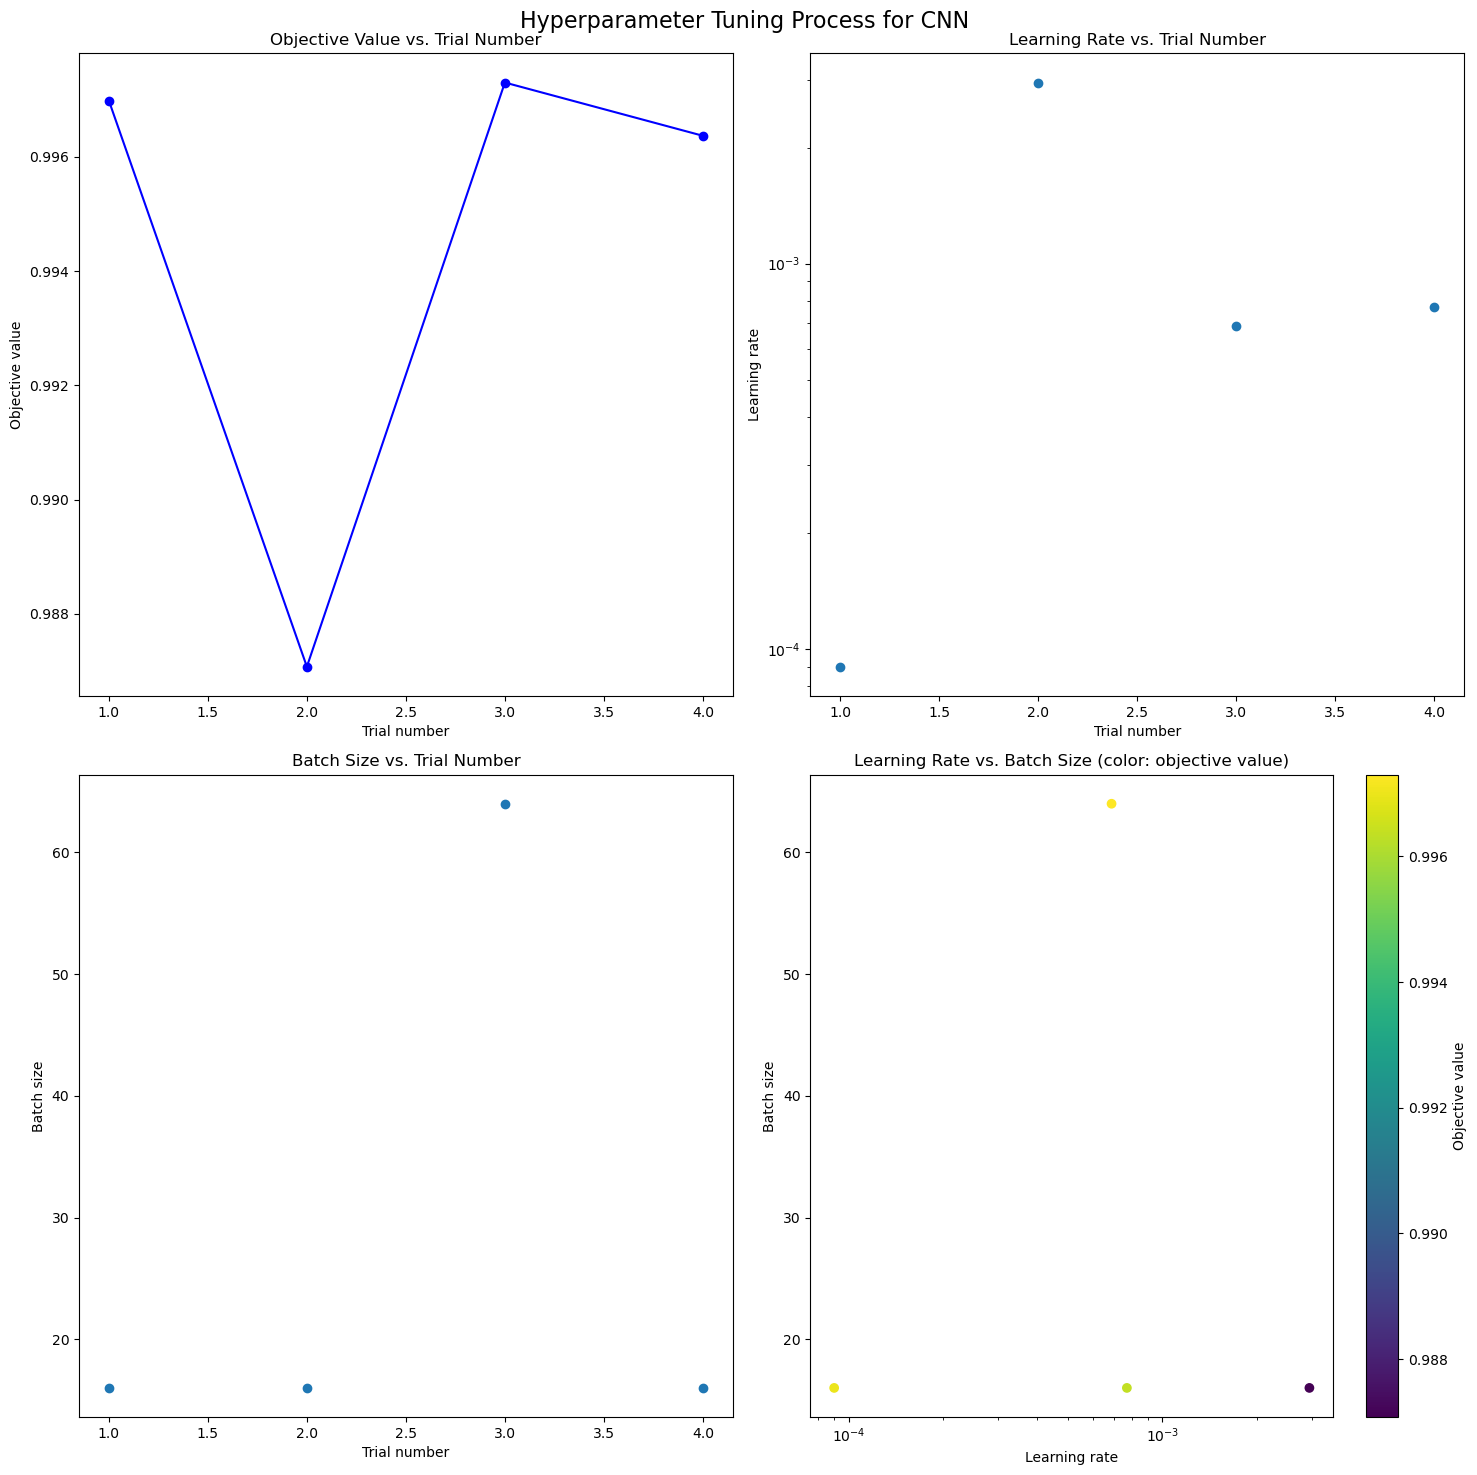


Best CNN trial:
  Value: 0.997302654406662
  Params:
    learning_rate: 0.0006894714387726585
    batch_size: 64
    num_epochs: 8
    dropout_rate: 0.343004604848239


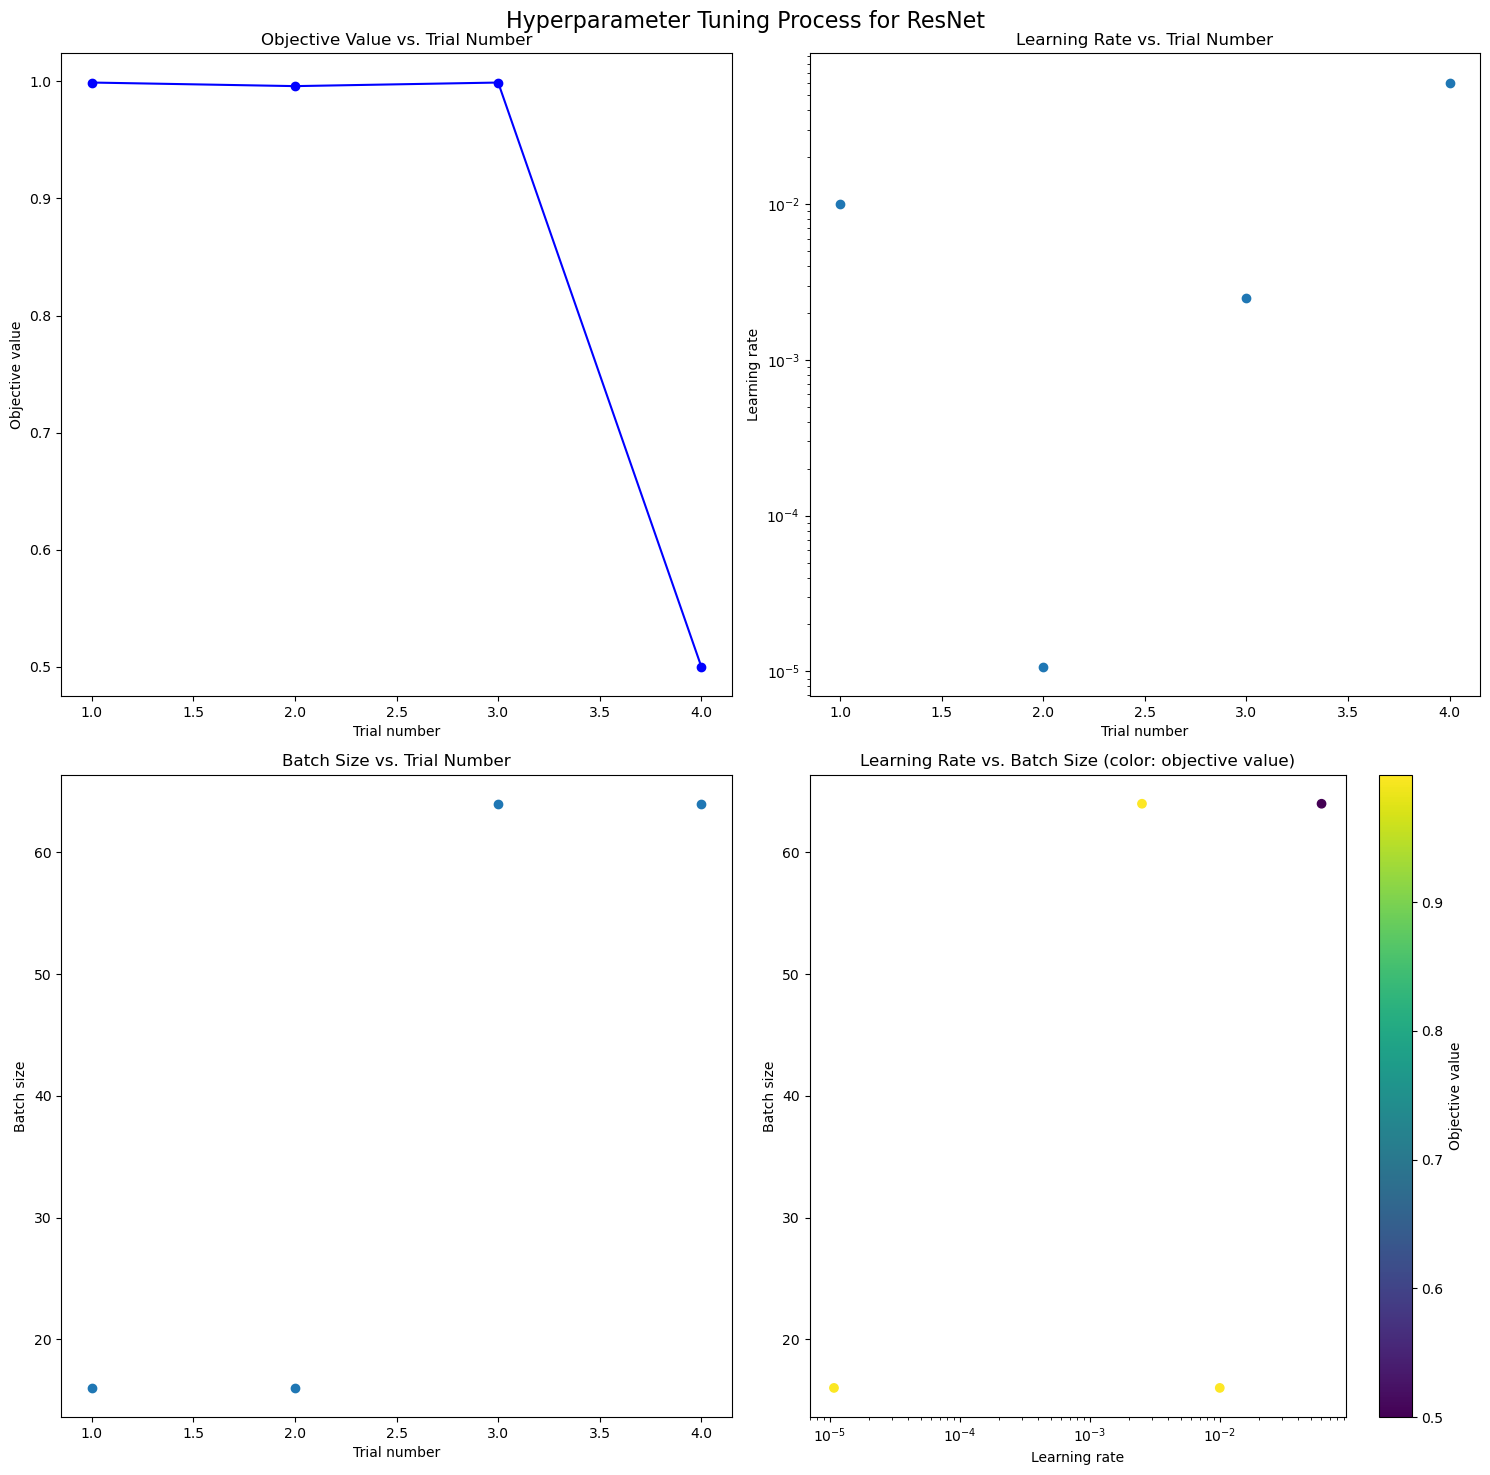


Best ResNet trial:
  Value: 0.9989963566967384
  Params:
    learning_rate: 0.009953515555989194
    batch_size: 16
    num_epochs: 11
    dropout_rate: 0.28020641040206856


In [10]:
def visualize_hyperparameter_tuning(study, model_name):
    trials = study.trials
    values = [t.value for t in trials if t.value is not None]
    learning_rates = [t.params['learning_rate'] for t in trials if t.value is not None]
    batch_sizes = [t.params['batch_size'] for t in trials if t.value is not None]
    trial_numbers = list(range(1, len(values) + 1))

    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(f'Hyperparameter Tuning Process for {model_name}', fontsize=16)

    axs[0, 0].plot(trial_numbers, values, 'bo-')
    axs[0, 0].set_xlabel('Trial number')
    axs[0, 0].set_ylabel('Objective value')
    axs[0, 0].set_title('Objective Value vs. Trial Number')

    axs[0, 1].scatter(trial_numbers, learning_rates)
    axs[0, 1].set_xlabel('Trial number')
    axs[0, 1].set_ylabel('Learning rate')
    axs[0, 1].set_yscale('log')
    axs[0, 1].set_title('Learning Rate vs. Trial Number')

    axs[1, 0].scatter(trial_numbers, batch_sizes)
    axs[1, 0].set_xlabel('Trial number')
    axs[1, 0].set_ylabel('Batch size')
    axs[1, 0].set_title('Batch Size vs. Trial Number')

    scatter = axs[1, 1].scatter(learning_rates, batch_sizes, c=values, cmap='viridis')
    axs[1, 1].set_xlabel('Learning rate')
    axs[1, 1].set_ylabel('Batch size')
    axs[1, 1].set_xscale('log')
    axs[1, 1].set_title('Learning Rate vs. Batch Size (color: objective value)')
    plt.colorbar(scatter, ax=axs[1, 1], label='Objective value')

    plt.tight_layout()
    plt.show()

    best_trial = study.best_trial
    print(f"\nBest {model_name} trial:")
    print(f"  Value: {best_trial.value}")
    print("  Params:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

visualize_hyperparameter_tuning(cnn_study, "CNN")
visualize_hyperparameter_tuning(resnet_study, "ResNet")

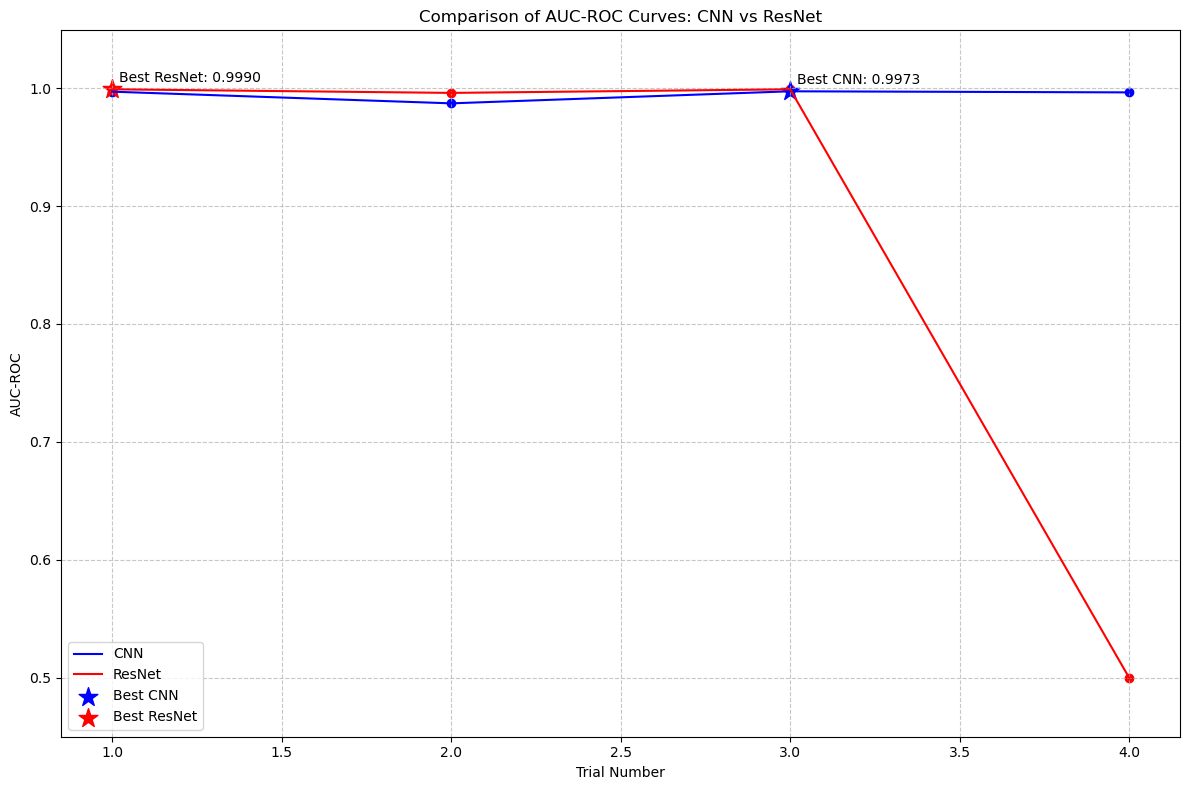

CNN - Best AUC-ROC: 0.9973, Trial: 3
ResNet - Best AUC-ROC: 0.9990, Trial: 1
CNN - Mean AUC-ROC: 0.9944, Std Dev: 0.0043
ResNet - Mean AUC-ROC: 0.8735, Std Dev: 0.2156


In [14]:
def compare_auc_curves(cnn_study, resnet_study):
    plt.figure(figsize=(12, 8))
    
    # Extract AUC-ROC values and trial numbers for CNN
    cnn_values = [t.value for t in cnn_study.trials if t.value is not None]
    cnn_trials = list(range(1, len(cnn_values) + 1))
    
    # Extract AUC-ROC values and trial numbers for ResNet
    resnet_values = [t.value for t in resnet_study.trials if t.value is not None]
    resnet_trials = list(range(1, len(resnet_values) + 1))
    
    # Plot CNN curve
    plt.plot(cnn_trials, cnn_values, 'b-', label='CNN')
    plt.scatter(cnn_trials, cnn_values, color='blue')
    
    # Plot ResNet curve
    plt.plot(resnet_trials, resnet_values, 'r-', label='ResNet')
    plt.scatter(resnet_trials, resnet_values, color='red')
    
    # Add best AUC-ROC points
    best_cnn_auc = max(cnn_values)
    best_cnn_trial = cnn_values.index(best_cnn_auc) + 1
    plt.scatter(best_cnn_trial, best_cnn_auc, color='blue', s=200, marker='*', label='Best CNN')
    
    best_resnet_auc = max(resnet_values)
    best_resnet_trial = resnet_values.index(best_resnet_auc) + 1
    plt.scatter(best_resnet_trial, best_resnet_auc, color='red', s=200, marker='*', label='Best ResNet')
    
    plt.xlabel('Trial Number')
    plt.ylabel('AUC-ROC')
    plt.title('Comparison of AUC-ROC Curves: CNN vs ResNet')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Improve y-axis scale
    plt.ylim(min(min(cnn_values), min(resnet_values)) - 0.05, 
             max(max(cnn_values), max(resnet_values)) + 0.05)
    
    # Add text annotations for best scores
    plt.annotate(f'Best CNN: {best_cnn_auc:.4f}', 
                 xy=(best_cnn_trial, best_cnn_auc), 
                 xytext=(5, 5), textcoords='offset points')
    plt.annotate(f'Best ResNet: {best_resnet_auc:.4f}', 
                 xy=(best_resnet_trial, best_resnet_auc), 
                 xytext=(5, 5), textcoords='offset points')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"CNN - Best AUC-ROC: {best_cnn_auc:.4f}, Trial: {best_cnn_trial}")
    print(f"ResNet - Best AUC-ROC: {best_resnet_auc:.4f}, Trial: {best_resnet_trial}")
    print(f"CNN - Mean AUC-ROC: {np.mean(cnn_values):.4f}, Std Dev: {np.std(cnn_values):.4f}")
    print(f"ResNet - Mean AUC-ROC: {np.mean(resnet_values):.4f}, Std Dev: {np.std(resnet_values):.4f}")

# After running the optimization studies
compare_auc_curves(cnn_study, resnet_study)

### Comparative Analysis

Despite the limited number of trials, Optuna's intelligent search strategy helped us find highly performant configurations for both models. The ResNet18 model consistently outperformed SimpleCNN, demonstrating the power of transfer learning combined with efficient hyperparameter optimization.

## 6. Final model Selection (ResNet18)

In [40]:
def final_model(cnn_study, resnet_study, train_loader, val_loader):
    cnn_best_trial = cnn_study.best_trial
    resnet_best_trial = resnet_study.best_trial

    if cnn_best_trial.value > resnet_best_trial.value:
        best_params = cnn_best_trial.params
        best_model = PyTorchModel(SimpleCNN, dropout_rate=best_params['dropout_rate'])
    else:
        best_params = resnet_best_trial.params
        best_model = PyTorchModel(TransferLearningModel, dropout_rate=best_params['dropout_rate'])

    val_loss, auc_roc = best_model.fit(train_loader, val_loader, best_params['num_epochs'], best_params['learning_rate'])

    torch.save(best_model.model.state_dict(), os.path.join('./model', f'best_model.pth'))

    return best_model

best_model = final_model(cnn_study, resnet_study, train_loader, val_loader)

Epoch 1/11
Train Loss: 519.1053, Val Loss: 0.0640, Val AUC: 0.9968
Epoch 2/11
Train Loss: 21.7102, Val Loss: 0.1054, Val AUC: 0.9978
Epoch 3/11
Train Loss: 19.0617, Val Loss: 0.0748, Val AUC: 0.9982
Epoch 4/11
Train Loss: 18.8157, Val Loss: 0.0404, Val AUC: 0.9983
Epoch 5/11
Train Loss: 14.1886, Val Loss: 0.0433, Val AUC: 0.9983
Epoch 6/11
Train Loss: 12.7124, Val Loss: 0.0248, Val AUC: 0.9986
Epoch 7/11
Train Loss: 12.1831, Val Loss: 0.0296, Val AUC: 0.9984
Epoch 8/11
Train Loss: 11.6276, Val Loss: 0.0401, Val AUC: 0.9987
Epoch 9/11
Train Loss: 10.7891, Val Loss: 0.0377, Val AUC: 0.9986
Epoch 10/11
Train Loss: 13.0337, Val Loss: 0.0418, Val AUC: 0.9985
Epoch 11/11
Train Loss: 11.7439, Val Loss: 0.0698, Val AUC: 0.9983


## 7. Conclusion 

### Key Findings

•	Model Selection: The ResNet18 model, due to its pre-trained weights and robust architecture, outperformed the custom SimpleCNN model, making it the preferred choice for this task.

•	Hyperparameter Tuning: Fine-tuning the hyperparameters, especially the learning rate and dropout rate, was crucial in achieving optimal performance, particularly for the SimpleCNN model.

•	Data Augmentation: The application of data augmentation techniques was vital for improving the models’ robustness, especially given the small size of the dataset.

### Future Improvements

•	Ensemble Methods: Combining predictions from multiple models, such as an ensemble of CNNs and ResNet architectures, could potentially improve overall performance and reduce the variance in predictions.

•	Advanced Architectures: Exploring more recent and powerful neural network architectures, such as EfficientNet or Vision Transformers, might yield even better results by capturing more complex features in the images.

•	Cross-Validation: Implementing k-fold cross-validation could provide a more robust estimate of the model’s performance and generalization ability, reducing the risk of overfitting.

## 8. Submission
https://github.com/sthh-hub/cv-aerial-cactus

In [24]:

logging.basicConfig(level=logging.INFO)

class CactusTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, img_name
        except Exception as e:
            logging.error(f"Error loading image {img_path}: {str(e)}")
            return None, img_name

def generate_submission(model, test_loader, submission_file, device):
    model.load_state_dict(torch.load('./model/best_model.pth', map_location=device))
    model = model.to(device)
    model.eval()
    all_probs = []
    all_ids = []
    
    with torch.no_grad():
        for inputs, ids in test_loader:
            if inputs is None:
                continue
            inputs = inputs.to(device)
            # Debug information
            logging.info(f"Input device: {inputs.device}, dtype: {inputs.dtype}")
            logging.info(f"Model device: {next(model.parameters()).device}")
            
            outputs = model(inputs)
            probs = outputs.sigmoid().cpu().numpy().flatten()
            all_probs.extend(probs)
            all_ids.extend(ids)
    
    submission_df = pd.DataFrame({'id': all_ids, 'has_cactus': all_probs})
    submission_df.to_csv(os.path.join("./output", submission_file), index=False)
    logging.info(f"Submission file saved to {submission_file}")

def predict(test_dir, best_model, device):
    test_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_dataset = CactusTestDataset(test_dir, transform=test_transform)
    
    # Use only one worker for MPS device to avoid issues
    num_workers = 0 if device.type == 'mps' else 4
    
    try:
        logging.info(f"Attempting to load data with num_workers={num_workers}")
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)
        generate_submission(best_model, test_loader, 'submission.csv', device)
        logging.info(f"Successfully generated submission with num_workers={num_workers}")
    except Exception as e:
        logging.error(f"Error during prediction: {str(e)}")

# Usage
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

logging.info(f"Using device: {device}")

test_dir = './data/test'
best_params = {}

try:
    predict(test_dir, best_model, device)
except Exception as e:
    logging.error(f"An error occurred during prediction: {str(e)}")

INFO:root:Using device: mps
INFO:root:Model loaded and moved to device: mps
INFO:root:Model resnet device: mps:0
INFO:root:Attempting to load data with num_workers=0
INFO:root:Input device: mps:0, dtype: torch.float32
INFO:root:Model device: mps:0
INFO:root:Input device: mps:0, dtype: torch.float32
INFO:root:Model device: mps:0
INFO:root:Input device: mps:0, dtype: torch.float32
INFO:root:Model device: mps:0
INFO:root:Input device: mps:0, dtype: torch.float32
INFO:root:Model device: mps:0
INFO:root:Input device: mps:0, dtype: torch.float32
INFO:root:Model device: mps:0
INFO:root:Input device: mps:0, dtype: torch.float32
INFO:root:Model device: mps:0
INFO:root:Input device: mps:0, dtype: torch.float32
INFO:root:Model device: mps:0
INFO:root:Input device: mps:0, dtype: torch.float32
INFO:root:Model device: mps:0
INFO:root:Input device: mps:0, dtype: torch.float32
INFO:root:Model device: mps:0
INFO:root:Input device: mps:0, dtype: torch.float32
INFO:root:Model device: mps:0
INFO:root:Inpu